# U-Net segmentation example
### Advanced Deep Learning 2022
This notebook was originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).

The U-Net is based on code written by Annika Brundyn and Akshay Kulkarni distributed as part of [*PyTorch Lightning Bolts*](https://pytorch-lightning.readthedocs.io/) under the  [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0.txt). 

We consider the data described in:

Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006


## Installs

If some packages are missing:

In [1]:
pip install -q pytorch_lightning lightning-bolts

     |████████████████████████████████| 584 kB 5.4 MB/s 
     |████████████████████████████████| 316 kB 18.8 MB/s 
     |████████████████████████████████| 136 kB 50.0 MB/s 
     |████████████████████████████████| 409 kB 43.9 MB/s 
     |████████████████████████████████| 596 kB 42.7 MB/s 
     |████████████████████████████████| 1.1 MB 34.5 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 271 kB 49.7 MB/s 
     |████████████████████████████████| 144 kB 54.0 MB/s 


## Imports

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn as nn
from torch.nn import functional as F
from torchvision.datasets.utils import download_url

import torchmetrics

from pprint import pformat
from skimage.transform import resize
#from sklearn.metrics import f1_score
from pathlib import Path
from glob import glob
from matplotlib.pyplot import imread
from collections import defaultdict

## Mount Google drive when using Google Colab

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Mounted at /content/gdrive/
Google drive not mounted


## Test for GPU support

In [4]:
# GPU support?
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


## U-Net
Import the U-Net.
  

In [5]:
from pl_bolts.models.vision import UNet

class Up(nn.Module):
    ##Upsampling: change the mode from bilinear to nearest

    def __init__(self, in_ch: int, out_ch: int, bilinear: bool = False):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest", align_corners=True),
                nn.Conv2d(in_ch, in_ch // 2, kernel_size=1),
            )
        else:
            self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)


class DoubleConv(nn.Module):
    """[ Conv2d => BatchNorm (optional) => ELU ] x 2."""

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            F.elu(out_ch),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            F.elu(out_ch),
        )



## Database

Load database with chest X-rays with lung segmentations.

In [6]:
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
  download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
  print('Using existing', data_fn)

  0%|          | 0/80938446 [00:00<?, ?it/s]

In [7]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask
    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

x train: (112, 1, 256, 256)
y train: (112, 1, 256, 256)
x val:  (12, 1, 256, 256)
y val:  (12, 1, 256, 256)
x test: (123, 1, 256, 256)
y test: (123, 1, 256, 256)


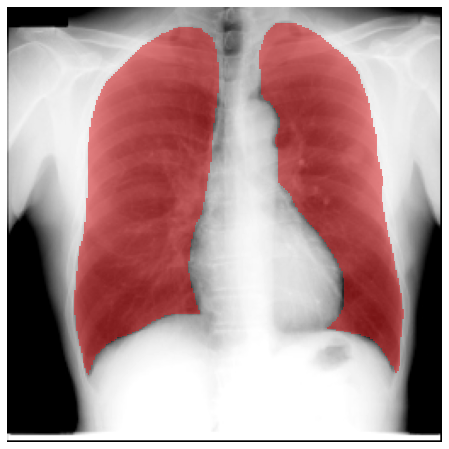

In [8]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)
# Bring images into PyTorch format
x_train = np.moveaxis(x_train, 3, 1)
y_train = np.moveaxis(y_train, 3, 1)
x_val = np.moveaxis(x_val, 3, 1)
y_val = np.moveaxis(y_val, 3, 1)
x_test = np.moveaxis(x_test, 3, 1)
y_test = np.moveaxis(y_test, 3, 1)

print("x train:", x_train.shape)
print("y train:", y_train.shape)
print("x val: ", x_val.shape)
print("y val: ", y_val.shape)
print("x test:", x_test.shape)
print("y test:", y_test.shape)

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

### Init torch dataloaders

In [9]:
def as_torch_dataset(x_arr, y_arr):
    """
    Takes two numpy arrays of data points and labels (x_arr and y_arr, respectively) and
    returns a torch TensorDataset object.
    
    Returns: torch.utils.data.TensorDataset
    """
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(x_arr), 
        torch.LongTensor(y_arr)
    )
    return dataset

# Init torch datasets
train_dataset = as_torch_dataset(x_train, y_train.squeeze(1))  # remove dummy channel dim
val_dataset = as_torch_dataset(x_val, y_val.squeeze(1))
test_dataset = as_torch_dataset(x_test, y_test.squeeze(1))

# Init dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

### Function for evaluating a model on a data loader

In [10]:
def evaluate_model(model, data_loader, metrics_dict, reduction=True, device=device):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.
    On each batch, compute all metric functions stored in dictionary 'metrics_dict'.
    
    Returns: dict of metric_name: (list of batch-wise metrics if reduction == False, else single scalar)
    """
    
    # defaultdict(list) returns a dictionary-like object with default_factory list. 
    # When a new key is encountered, an entry is automatically created of type default_factory. 
    metrics = defaultdict(list)
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            # Predict on batch
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)
            
            # Compute all metrics
            for metric_name, metric_func in metrics_dict.items():
                value = metric_func(logits.cpu(), batch_y.cpu()).item() #.cpu().numpy()
                metrics[metric_name].append(value)
    
    if reduction == True:
        # Return mean values
        return {key: np.mean(value) for key, value in metrics.items()}
    else:
        return metrics


## Main trainig loop function(s)

We want to track the F1 score during training. This generates some additional code. 

In [11]:
def run_one_epoch(model, loss, optimizer, train_loader, val_loader, n_epochs, metrics_dict, device=device):
    """
    Run 1 epoch of training
    Changes to model parameters and optimizer occour internally (state updates)
    Returns:
        two dictionaries, training and a validation metrics
    """
    train_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        # Zero out stored gradients for all parameters
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        
        print(f"   -- Batch {i+1}/{len(train_loader)}", end=" / ")
        # Predict on batch
        logits = model(batch_x)
        
        # Compute loss function
        loss_tensor = loss(logits, batch_y)
        loss_scalar = loss_tensor.detach().cpu().numpy()
        train_losses.append(loss_scalar)
        print("Loss: ", loss_scalar)
        
        # Backprop and step
        loss_tensor.backward()
        optimizer.step()
        
    # Run validation
    print("   Validation running...")
    val_metrics = evaluate_model(
        model=model, 
        data_loader=val_loader,
        metrics_dict=metrics_dict
    )
    # Return loss and metrics as dicts
    return {"loss": np.mean(train_losses)}, val_metrics


def merge_list_of_dicts(list_of_dicts):
    """
    Takes a list of dictionaries and merges them into a single dictionary pointing to lists
    
    E.g. [{"loss": 5}, {"loss": 3}, {"loss": -2, "F1": 0.5}] --> {"loss": [5, 3, -2], "F1": [0.5]}
    
    Returns: dict
    """
    merged = defaultdict(list)
    for dict_ in list_of_dicts:
        for value, key in dict_.items():
            merged[value].append(key)
    return merged


def training_loop(model, loss, optimizer, train_loader, val_loader, n_epochs, init_epoch=None, metrics_dict=None, save_path=None):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    Supports computing additional metrics on the validation set (only) via the metrics_dict param.
    Specify save_path to store the model at each epoch.
    
    Returns: 
        Two lists of metric dictionaries for each epoch for training and validation, specifically
    """
    train_history, val_history = [], []
    
    metrics_with_loss = {"loss": loss}
    if metrics_dict is not None:
        metrics_with_loss.update(metrics_dict)
    
    if init_epoch == None:
        init_epoch = 0
    try:
        for i in range(init_epoch, n_epochs):
            print(f"Epoch {i+1}/{n_epochs}")
            train_metrics, val_metrics = run_one_epoch(
                model=model, 
                loss=loss, 
                optimizer=optimizer, 
                train_loader=train_loader, 
                val_loader=val_loader, 
                n_epochs=n_epochs,
                metrics_dict=metrics_with_loss
            )
            print("   Mean epoch metrics:")
            print(f"   Training:   {pformat(train_metrics)}")
            print(f"   Validation: {pformat(val_metrics)}")
            train_history.append(train_metrics), val_history.append(val_metrics)
            
            if save_path:
                save_path_epoch = f"epoch_{i+1}_{save_path}"
                print(f"   Saving to: {save_path_epoch}")
                save_model(model, save_path_epoch, optimizer)
    except KeyboardInterrupt:
        print("Training stopped.")
        pass
    
    # Merge list of training and validation dicts into single dicts    
    return merge_list_of_dicts(train_history), merge_list_of_dicts(val_history)


## Function for plotting training/validation histories

In [12]:
def plot_histories(train_history=None, val_history=None, label="Loss"):
    """
    Takes a list of training and/or validation metrics and plots them
    Returns: plt.figure and ax objects
    """
    if not train_history and not val_history:
        raise ValueError("Must specify at least one of 'train_histories' and 'val_histories'")
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    
    epochs = np.arange(len(train_history or val_history))
    if train_history:
        ax.plot(epochs, train_history, label="Training", color="black")
    if val_history:
        ax.plot(epochs, val_history, label="Validation", color="darkred")
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend(loc=0)
    
    return fig, ax

## Functions for saving and loading model and optimizer state

In [13]:
def save_model(model, path, optimizer=None):
    """
    Saves the state_dict of a torch model and optional optimizer to 'path'
    Returns: None
    """
    state = {"model": model.state_dict()}
    if optimizer is not None:
        state["optimizer"] = optimizer.state_dict()
    torch.save(state, path)


def load_model(model, path, optimizer=None):
    """
    Loads the state_dict of a torch model and optional optimizer from 'path'
    Returns: None
    """
    state = torch.load(path)
    model.load_state_dict(state["model"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])


## Init U-Net model and optimizer

In [14]:
# Init U-Net model
model = UNet(
    num_classes=2, 
    input_channels=1, 
    num_layers=4, 
    features_start=16,
)

model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Continue training?

In [15]:
# Specify integer, starting at 1
init_epoch = None
if init_epoch != None:
    load_model(model, f"epoch_{init_epoch}_model.ckpt", optimizer)

## Run training

In [16]:
# Define loss and metrics
loss = torch.nn.CrossEntropyLoss(reduction="mean")
metrics = {"f1": torchmetrics.classification.F1Score(num_classes=2, average="macro", mdmc_average="samplewise")}

# Run training
train_history, val_history = training_loop(
    model=model,
    loss=loss, 
    optimizer=optimizer, 
    train_loader=train_loader, 
    val_loader=val_loader,
    init_epoch=init_epoch,
    n_epochs=100,
    metrics_dict=metrics,
    save_path="model.ckpt"
)

Epoch 1/100
   -- Batch 1/7 / Loss:  0.8058832
   -- Batch 2/7 / Loss:  0.78408176
   -- Batch 3/7 / Loss:  0.7668971
   -- Batch 4/7 / Loss:  0.74914664
   -- Batch 5/7 / Loss:  0.7394712
   -- Batch 6/7 / Loss:  0.7259368
   -- Batch 7/7 / Loss:  0.7083502
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.75425243}
   Validation: {'f1': 0.6395320892333984, 'loss': 0.7020161747932434}
   Saving to: epoch_1_model.ckpt
Epoch 2/100
   -- Batch 1/7 / Loss:  0.70447516
   -- Batch 2/7 / Loss:  0.6935801
   -- Batch 3/7 / Loss:  0.68352675
   -- Batch 4/7 / Loss:  0.6697831
   -- Batch 5/7 / Loss:  0.6693943
   -- Batch 6/7 / Loss:  0.6551485
   -- Batch 7/7 / Loss:  0.64869356
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.67494303}
   Validation: {'f1': 0.738896369934082, 'loss': 0.6372832655906677}
   Saving to: epoch_2_model.ckpt
Epoch 3/100
   -- Batch 1/7 / Loss:  0.63986176
   -- Batch 2/7 / Loss:  0.6396731
   -- Batch 3/7 / Loss:  

## Plot training and validation histories

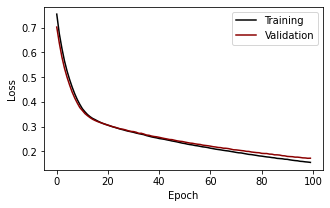

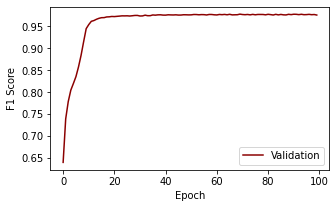

In [17]:
plot_histories(train_history['loss'], val_history['loss'], label="Loss")
plot_histories(train_history=None, val_history=val_history['f1'], label="F1 Score")
plt.show()

## Evaluate on single test-set image

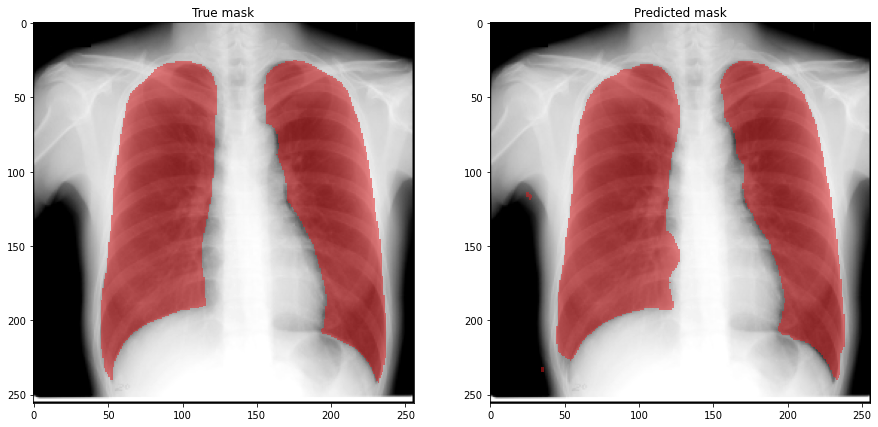

In [18]:
# Predict on a test image
x_test, y_test = test_dataset[0]
if gpu:
  x_test = x_test.to(device)
  y_test = y_test.to(device)
pred = model(x_test.view(1, 1, x_test.shape[1], x_test.shape[2])).argmax(1).cpu().numpy()

# Plot the result
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))
ax1.set_title("True mask")
ax2.set_title("Predicted mask")

plot_image_with_segmentation(x_test.cpu(), y_test.cpu(), ax=ax1)
plot_image_with_segmentation(x_test.cpu(), pred, ax=ax2)

plt.show()

## Evaluate on whole test-set

In [19]:
# OBS: Returns batch-wise metrics, but test_loader has batch_size = 1
f1_test_scores = evaluate_model(model, test_loader, metrics, reduction=False)["f1"]

print("Test cases:", len(f1_test_scores))
print("Mean F1:   ", np.mean(f1_test_scores))
print("STD  F1:   ", np.std(f1_test_scores))
print("Min. F1:   ", np.min(f1_test_scores))

Test cases: 123
Mean F1:    0.9751274794097838
STD  F1:    0.013571676728699642
Min. F1:    0.928501307964325
